### Demonstration of Aggregate Prediction Algorithms (Weighted Score and Majority Voting)

In [1]:
import helper, algorithm
import pandas as pd
import joblib
import time
import warnings
warnings.simplefilter('ignore')

1. Testing of each model and demonstration of model aggregate prediction algorithms

In [2]:
# Temporarily switch the root directory to the upper level to avoid not finding the dataset files.
import os
os.chdir('..')


Client 1 Prediction Results:
*******************
Accuracy : 0.908894
Precision: 0.909236
Recall   : 0.908894
F1 Score : 0.909026
*******************


Client 2 Prediction Results:
*******************
Accuracy : 0.911843
Precision: 0.911825
Recall   : 0.911843
F1 Score : 0.911834
*******************


Client 3 Prediction Results:
*******************
Accuracy : 0.913343
Precision: 0.913502
Recall   : 0.913343
F1 Score : 0.913411
*******************


Server Prediction Results:
*******************
Accuracy : 0.994618
Precision: 0.994621
Recall   : 0.994618
F1 Score : 0.994619
*******************



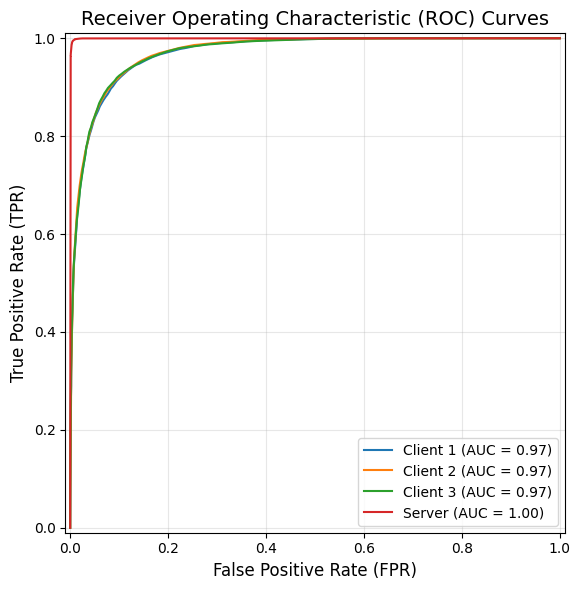

In [3]:
# Load the testing set
sensor_test, network_test = helper.load_test_set()

# Load the models
sensor_models = ['./received_models/client_1.joblib',
                 './received_models/client_2.joblib',
                 './received_models/client_3.joblib']

network_model = './received_models/global_model.joblib'

# Test models 
models_predictions, models_metrics = algorithm.get_predictions_and_metrics(
    local_models=sensor_models,
    sensor_test=sensor_test,
    global_model=network_model,
    network_test=network_test,
)

In [4]:
# Load network testing set, set the weights
y_test = network_test.iloc[:, -1]
model_weights = [0.2, 0.2, 0.2, 0.4]

In [5]:
print(f"Aggregate Prediction by Weighted Score:")

score = algorithm.aggregate_predict_by_score(
    models_predictions=models_predictions,
    models_metrics=models_metrics,
    models_weights=model_weights)

helper.get_metrics(y_test, score, printout=True)

Aggregate Prediction by Weighted Score:
*******************
Accuracy : 0.975743
Precision: 0.975817
Recall   : 0.975743
F1 Score : 0.975765
*******************



(0.9757428297574283,
 0.9758173728699214,
 0.9757428297574283,
 0.9757645243660202)

In [6]:
print(f"Aggregate Prediction by Majority Voting:")

vote = algorithm.aggregate_predict_by_vote(models_predictions=models_predictions)

helper.get_metrics(y_test, vote, printout=True)

Aggregate Prediction by Majority Voting:
*******************
Accuracy : 0.958343
Precision: 0.962304
Recall   : 0.958343
F1 Score : 0.958664
*******************



(0.9583425495834255,
 0.9623041347221168,
 0.9583425495834255,
 0.9586635341813992)

2. Simulation of intrusion detection

In [7]:
sensor_test['target'].value_counts()

target
0    24859
1    15830
Name: count, dtype: int64

In [8]:
# Select 10000 equally distributed samples from the testing set
s0 = sensor_test[sensor_test['target'] == 0].sample(10000)
s1 = sensor_test[sensor_test['target'] == 1].sample(10000)

sampled_sensor_data = pd.concat([s0, s1])
sampled_network_data = network_test.loc[sampled_sensor_data.index]

sampled_sensor_data = sampled_sensor_data.reset_index(drop=True)
sampled_network_data = sampled_network_data.reset_index(drop=True)

print(sampled_sensor_data['target'].value_counts())
print(sampled_network_data['target'].value_counts())

target
0    10000
1    10000
Name: count, dtype: int64
target
0    10000
1    10000
Name: count, dtype: int64


In [9]:
# Use Client 1 as an example
client_1_model = joblib.load('./received_models/client_1.joblib')

test_X = sampled_sensor_data.iloc[:, :-1]
test_y = sampled_sensor_data.iloc[:, -1]

client_1_predict = client_1_model.predict(test_X)

helper.get_metrics(test_y, client_1_predict, printout=True)

*******************
Accuracy : 0.903500
Precision: 0.903888
Recall   : 0.903500
F1 Score : 0.903477
*******************



(0.9035, 0.9038881364991758, 0.9035, 0.9034768103036754)

In [10]:
client_1_predict_df = pd.DataFrame(client_1_predict, columns=['Pred'])
client_1_predict_df['Pred'].value_counts()

Pred
0    10310
1     9690
Name: count, dtype: int64

In [11]:
# Client 1 will test the sensor data locally, only those that pass will be sent to the server
# Drop false data, target = 1
rows_to_keep = client_1_predict_df['Pred'] == 0
filtered_sensor_data = sampled_sensor_data[rows_to_keep]
filtered_network_data = sampled_network_data[rows_to_keep]

print(filtered_sensor_data['target'].value_counts())
print(filtered_network_data['target'].value_counts())

target
0    9190
1    1120
Name: count, dtype: int64
target
0    9190
1    1120
Name: count, dtype: int64



Client 1 Prediction Results:
*******************
Accuracy : 0.891368
Precision: 0.794536
Recall   : 0.891368
F1 Score : 0.840171
*******************


Client 2 Prediction Results:
*******************
Accuracy : 0.916586
Precision: 0.912720
Recall   : 0.916586
F1 Score : 0.914384
*******************


Client 3 Prediction Results:
*******************
Accuracy : 0.920563
Precision: 0.917929
Recall   : 0.920563
F1 Score : 0.919111
*******************


Server Prediction Results:
*******************
Accuracy : 0.994568
Precision: 0.994761
Recall   : 0.994568
F1 Score : 0.994616
*******************



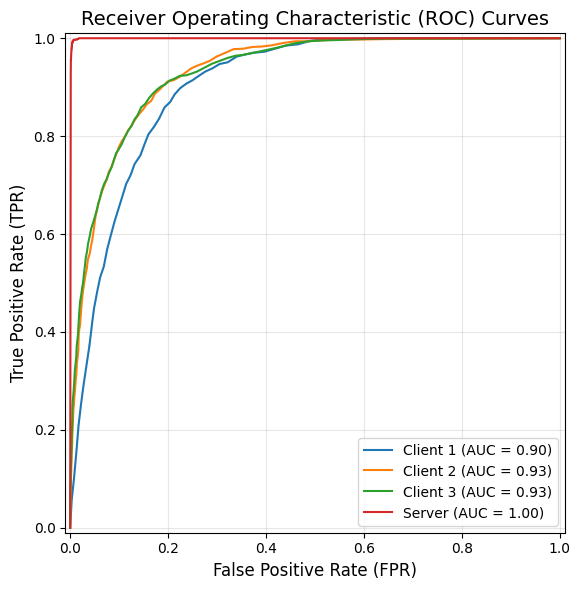

In [12]:
# Test Client 1 data using all models
new_models_predictions, new_models_metrics = algorithm.get_predictions_and_metrics(
    local_models=sensor_models,
    sensor_test=filtered_sensor_data,
    global_model=network_model,
    network_test=filtered_network_data,
)

In [13]:
# Load Client 1 network testing set
new_y_test = filtered_network_data.iloc[:, -1]

In [14]:
print(f"Client 1 Aggregate Prediction by Weighted Score:")
start_time = time.time()

new_score = algorithm.aggregate_predict_by_score(
    models_predictions=new_models_predictions,
    models_metrics=new_models_metrics,
    models_weights=model_weights)

end_time = time.time()
rows = len(new_models_predictions[0])
time_spend = end_time - start_time

helper.get_metrics(new_y_test, new_score, printout=True)
print(f"Time spent predicting {rows} samples: {time_spend:.4f}s, average time spent: {time_spend / rows:.4f}s.")

Client 1 Aggregate Prediction by Weighted Score:
*******************
Accuracy : 0.973715
Precision: 0.974244
Recall   : 0.973715
F1 Score : 0.972179
*******************

Time spent predicting 10310 samples: 0.0000s, average time spent: 0.0000s.


In [15]:
print(f"Client 1 Aggregate Prediction by Majority Voting:")
start_time = time.time()

new_vote = algorithm.aggregate_predict_by_vote(models_predictions=new_models_predictions)

end_time = time.time()
time_spend = end_time - start_time

helper.get_metrics(new_y_test, new_vote, printout=True)
print(f"Time spent predicting {rows} samples: {time_spend:.4f}s, average time spent: {time_spend / rows:.4f}s.")

Client 1 Aggregate Prediction by Majority Voting:
*******************
Accuracy : 0.983220
Precision: 0.985282
Recall   : 0.983220
F1 Score : 0.983714
*******************

Time spent predicting 10310 samples: 0.0050s, average time spent: 0.0000s.
